In [1]:
# Step 1: Install Required Packages
!pip install pandas matplotlib seaborn plotly wordcloud

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import json
from datetime import datetime
import plotly.express as px
from wordcloud import WordCloud
from pathlib import Path
import sqlite3

print("All packages imported successfully!")

All packages imported successfully!


In [2]:
# Step 2: WhatsApp Message Extraction and Conversion Class

class WhatsAppRealEstateProcessor:
    def __init__(self):
        self.raw_messages = []
        self.clean_messages = []
        self.parsed_data = []
        self.df = None
        
    def load_whatsapp_export(self, file_path):
        """Load and parse WhatsApp exported .txt file"""
        try:
            # Try different encodings
            encodings = ['utf-8', 'utf-16', 'latin-1', 'iso-8859-1']
            
            for encoding in encodings:
                try:
                    with open(file_path, 'r', encoding=encoding) as file:
                        content = file.read()
                    print(f"File loaded successfully with {encoding} encoding")
                    break
                except UnicodeDecodeError:
                    continue
            else:
                raise ValueError("Could not decode file with any encoding")
            
            # Parse messages
            lines = content.split('\n')
            current_message = ""
            
            for line in lines:
                line = line.strip()
                if not line:
                    continue
                    
                # Check if this is a new message (starts with date pattern)
                if self._is_new_message(line):
                    if current_message:
                        self.raw_messages.append(current_message)
                    current_message = line
                else:
                    # Continuation of previous message
                    if current_message:
                        current_message += " " + line
                    else:
                        current_message = line
            
            # Add the last message
            if current_message:
                self.raw_messages.append(current_message)
                
            print(f"✅ Successfully loaded {len(self.raw_messages)} raw messages")
            return self.raw_messages
            
        except Exception as e:
            print(f"❌ Error loading file: {e}")
            return []
    
    def _is_new_message(self, line):
        """Check if line starts a new WhatsApp message"""
        patterns = [
            r'^\d{1,2}/\d{1,2}/\d{2,4}, \d{1,2}:\d{2}',  # 28/08/2023, 10:15
            r'^\[\d{1,2}/\d{1,2}/\d{2,4},',              # [28/08/2023,
            r'^\d{1,2}\.\d{1,2}\.\d{2,4}',               # 28.08.2023
        ]
        return any(re.match(pattern, line) for pattern in patterns)
    
    def extract_clean_messages(self):
        """Extract only the message content without metadata"""
        self.clean_messages = []
        
        for msg in self.raw_messages:
            # Extract message part (after the last colon which usually contains sender)
            parts = msg.split(':', 3)  # Split into max 4 parts
            if len(parts) >= 4:
                message_text = parts[3].strip()
            elif len(parts) >= 2:
                message_text = parts[-1].strip()
            else:
                message_text = msg
            
            if message_text and len(message_text) > 5:  # Filter very short messages
                self.clean_messages.append(message_text)
        
        print(f"✅ Extracted {len(self.clean_messages)} clean messages")
        return self.clean_messages

# Initialize the processor
processor = WhatsAppRealEstateProcessor()

In [15]:
# Step 3: Load Your WhatsApp Export File
# Replace 'chat.txt' with your actual file path

file_path = "texts.txt"  # Change this to your file path

# Load the messages
raw_messages = processor.load_whatsapp_export(file_path)

# Extract clean messages
clean_messages = processor.extract_clean_messages()

# Display sample messages
print("\n📝 Sample Messages:")
for i, msg in enumerate(clean_messages[:10]):
    print(f"{i+1}. {msg}")

File loaded successfully with utf-8 encoding
✅ Successfully loaded 898 raw messages
✅ Extracted 898 clean messages

📝 Sample Messages:
1. 2BHK available for rent in Andheri East. 1100 sqft, semi-furnished, 65k rent. Near metro station. Contact: 9812312345
2. 3BHK luxury flat for sale in Powai. 1850 sqft, 4.2 Cr. Sea facing, clubhouse, 3 parking. Call 9823412345 for site visit.
3. 1RK studio apartment available in Lokhandwala. 450 sqft, fully furnished, 25k rent. Ideal for bachelors. WhatsApp for pics: 9876543210
4. Shop space available in Bandra West. 800 sqft, 1.5L rent. Main road, good footfall. Immediate possession. Contact: 9898765432
5. 2BHK ready to move flat in Malad West. 1200 sqft, 1.8Cr. 2nd floor, park facing. No brokerage. Serious buyers only: 9811122233
6. 3BHK duplex for rent in Juhu. 2200 sqft, 1.2L rent. 3 bathrooms, modular kitchen. Available from next month. Call 9822233344
7. 1BHK budget flat in Kandivali East. 650 sqft, 42k rent. Near station, market area. Security 

In [17]:
# Step 4: Simplified and Robust Real Estate Data Parser

class SimpleRealEstateParser:
    def __init__(self):
        self.locations = [
            'andheri', 'bandra', 'powai', 'juhu', 'worli', 'malad', 'borivali', 'kandivali',
            'goregaon', 'santacruz', 'vile parle', 'chembur', 'ghatkopar', 'thane',
            'navi mumbai', 'lower parel', 'dadar', 'mahim', 'bhandup', 'mulund', 'lokhandwala',
            'vashi', 'seawoods', 'bhiwandi'
        ]
        
    def safe_extract(self, pattern, text, group=1, default=None):
        """Safely extract regex pattern with error handling"""
        try:
            match = re.search(pattern, text, re.IGNORECASE)
            if match and match.group(group):
                return match.group(group)
            return default
        except:
            return default
    
    def parse_message(self, message):
        """Parse a single message and extract real estate data"""
        message_lower = message.lower()
        
        # Initialize result dictionary
        result = {
            'original_message': message,
            'property_type': None,
            'area_sqft': None,
            'price': None,
            'price_unit': None,
            'rent': None,
            'rent_unit': None,
            'location': None,
            'furnishing': None,
            'transaction_type': None,
            'contact': None,
            'is_real_estate': False
        }
        
        # Check if this is a real estate message
        real_estate_keywords = ['bhk', 'rk', 'sqft', 'rent', 'sale', 'flat', 'apartment', 'property']
        if not any(keyword in message_lower for keyword in real_estate_keywords):
            return result
        
        result['is_real_estate'] = True
        
        # Extract Property Type
        bhk_match = self.safe_extract(r'(\d)\s*(bhk|rk)', message_lower)
        if bhk_match:
            result['property_type'] = bhk_match
        
        # Extract Area
        area_match = self.safe_extract(r'(\d+)\s*sq\s*ft', message_lower)
        if area_match:
            result['area_sqft'] = int(area_match)
        
        # Extract Rent
        rent_match_k = self.safe_extract(r'(\d+)\s*k\s*rent', message_lower) or self.safe_extract(r'rent\s*(\d+)\s*k', message_lower)
        if rent_match_k:
            result['rent'] = int(rent_match_k) * 1000
            result['rent_unit'] = 'K'
            result['transaction_type'] = 'rent'
        
        rent_match_l = self.safe_extract(r'(\d+(?:\.\d+)?)\s*(l|lakh)\s*rent', message_lower)
        if rent_match_l and not result['rent']:
            result['rent'] = float(rent_match_l) * 100000
            result['rent_unit'] = 'L'
            result['transaction_type'] = 'rent'
        
        # Extract Sale Price (only if no rent found)
        if not result['rent']:
            price_cr = self.safe_extract(r'(\d+(?:\.\d+)?)\s*(cr|crore)', message_lower)
            if price_cr:
                result['price'] = float(price_cr) * 10000000
                result['price_unit'] = 'CR'
                result['transaction_type'] = 'sale'
            else:
                price_lakh = self.safe_extract(r'(\d+(?:\.\d+)?)\s*(lakh|lac)', message_lower)
                if price_lakh:
                    result['price'] = float(price_lakh) * 100000
                    result['price_unit'] = 'L'
                    result['transaction_type'] = 'sale'
        
        # Extract Location
        for location in self.locations:
            if location in message_lower:
                result['location'] = location.title()
                break
        
        # Extract Contact
        contact = self.safe_extract(r'(\d{10})', message)
        if contact:
            result['contact'] = contact
        
        return result
    
    def parse_all_messages(self, messages):
        """Parse all messages and return DataFrame"""
        parsed_data = []
        
        for i, message in enumerate(messages):
            try:
                parsed_msg = self.parse_message(message)
                if parsed_msg['is_real_estate']:
                    parsed_data.append(parsed_msg)
            except Exception as e:
                print(f"Error parsing message {i}: {e}")
                print(f"Problematic message: {message[:100]}...")
                continue
        
        df = pd.DataFrame(parsed_data)
        print(f"✅ Successfully parsed {len(df)} real estate listings")
        return df

# Use the simple parser instead
parser = SimpleRealEstateParser()
df = parser.parse_all_messages(clean_messages)

# Display the parsed data
print("\n📊 Parsed Data Sample:")
if len(df) > 0:
    display(df.head(10))
else:
    print("No real estate listings found. Check your messages format.")

✅ Successfully parsed 863 real estate listings

📊 Parsed Data Sample:


,original_message,property_type,area_sqft,price,price_unit,rent,rent_unit,location,furnishing,transaction_type,contact,is_real_estate
0,2BHK available for rent in Andheri East. 1100 ...,2,1100.0,NaN,None,65000.0,K,Andheri,None,rent,9812312345,True
1,"3BHK luxury flat for sale in Powai. 1850 sqft,...",3,1850.0,42000000.0,CR,NaN,None,Powai,None,sale,9823412345,True
2,1RK studio apartment available in Lokhandwala....,1,450.0,NaN,None,25000.0,K,Lokhandwala,None,rent,9876543210,True
3,"Shop space available in Bandra West. 800 sqft,...",None,800.0,NaN,None,150000.0,L,Bandra,None,rent,9898765432,True
4,2BHK ready to move flat in Malad West. 1200 sq...,2,1200.0,18000000.0,CR,NaN,None,Malad,None,sale,9811122233,True
5,"3BHK duplex for rent in Juhu. 2200 sqft, 1.2L ...",3,2200.0,NaN,None,120000.0,L,Juhu,None,rent,9822233344,True
6,"1BHK budget flat in Kandivali East. 650 sqft, ...",1,650.0,NaN,None,42000.0,K,Kandivali,None,rent,9833344455,True
7,"4BHK penthouse for sale in Worli. 3200 sqft, 8...",4,3200.0,85000000.0,CR,NaN,None,Worli,None,sale,9844455566,True
8,Commercial office available in Lower Parel. 15...,None,1500.0,NaN,None,90000.0,K,Lower Parel,None,rent,9855566677,True
9,"2BHK resale flat in Goregaon East. 950 sqft, 1...",2,950.0,11000000.0,CR,NaN,None,Goregaon,None,sale,9866677788,True


In [19]:
# Step 5: Data Cleaning and Enhancement

def enhance_real_estate_data(df):
    """Clean and enhance the parsed real estate data"""
    
    # Create a copy to avoid warnings
    enhanced_df = df.copy()
    
    # Convert price to lakhs for easier visualization
    enhanced_df['price_lakhs'] = enhanced_df['price'] / 100000
    enhanced_df['rent_thousands'] = enhanced_df['rent'] / 1000
    
    # Extract BHK number for sorting
    enhanced_df['bhk_number'] = enhanced_df['property_type'].str.extract(r'(\d)').astype(float)
    
    # Create price categories
    def categorize_price(price):
        if pd.isna(price):
            return None
        elif price < 50:
            return '0-50 L'
        elif price < 100:
            return '50L-1Cr'
        elif price < 200:
            return '1-2Cr'
        elif price < 500:
            return '2-5Cr'
        else:
            return '5Cr+'
    
    enhanced_df['price_category'] = enhanced_df['price_lakhs'].apply(categorize_price)
    
    # Create rent categories
    def categorize_rent(rent):
        if pd.isna(rent):
            return None
        elif rent < 20:
            return '0-20k'
        elif rent < 40:
            return '20-40k'
        elif rent < 60:
            return '40-60k'
        elif rent < 100:
            return '60k-1L'
        else:
            return '1L+'
    
    enhanced_df['rent_category'] = enhanced_df['rent_thousands'].apply(categorize_rent)
    
    print("✅ Data enhancement completed!")
    return enhanced_df

# Enhance the data
enhanced_df = enhance_real_estate_data(df)

# Display enhanced data
print("\n📈 Enhanced Data Info:")
print(enhanced_df.info())
print(f"\nTotal real estate listings: {len(enhanced_df)}")

✅ Data enhancement completed!

📈 Enhanced Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863 entries, 0 to 862
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   original_message  863 non-null    object 
 1   property_type     677 non-null    object 
 2   area_sqft         860 non-null    float64
 3   price             284 non-null    float64
 4   price_unit        284 non-null    object 
 5   rent              476 non-null    float64
 6   rent_unit         476 non-null    object 
 7   location          790 non-null    object 
 8   furnishing        0 non-null      object 
 9   transaction_type  760 non-null    object 
 10  contact           861 non-null    object 
 11  is_real_estate    863 non-null    bool   
 12  price_lakhs       284 non-null    float64
 13  rent_thousands    476 non-null    float64
 14  bhk_number        677 non-null    float64
 15  price_category    284 non-null    obje

In [21]:
# Step 6: Data Storage

def store_data(enhanced_df):
    """Store data in multiple formats"""
    
    # 1. Save to CSV
    enhanced_df.to_csv('real_estate_listings.csv', index=False)
    print("✅ Data saved to real_estate_listings.csv")
    
    # 2. Save to Excel with multiple sheets
    with pd.ExcelWriter('real_estate_analysis.xlsx') as writer:
        enhanced_df.to_excel(writer, sheet_name='All_Listings', index=False)
        
        # Summary statistics
        summary_stats = pd.DataFrame({
            'Metric': ['Total Listings', 'Rental Listings', 'Sale Listings', 'Unique Locations', 'Unique Brokers'],
            'Value': [
                len(enhanced_df),
                len(enhanced_df[enhanced_df['transaction_type'] == 'rent']),
                len(enhanced_df[enhanced_df['transaction_type'] == 'sale']),
                enhanced_df['location'].nunique(),
                enhanced_df['contact'].nunique()
            ]
        })
        summary_stats.to_excel(writer, sheet_name='Summary', index=False)
    
    print("✅ Data saved to real_estate_analysis.xlsx")
    
    # 3. Save to SQLite Database
    conn = sqlite3.connect('real_estate.db')
    enhanced_df.to_sql('listings', conn, if_exists='replace', index=False)
    
    # Create a summary table
    summary_query = """
    CREATE TABLE IF NOT EXISTS summary AS
    SELECT 
        transaction_type,
        COUNT(*) as count,
        AVG(price_lakhs) as avg_price_lakhs,
        AVG(rent_thousands) as avg_rent_thousands,
        AVG(area_sqft) as avg_area_sqft
    FROM listings
    GROUP BY transaction_type
    """
    conn.execute(summary_query)
    conn.commit()
    conn.close()
    
    print("✅ Data saved to real_estate.db (SQLite)")
    
    return {
        'csv': 'real_estate_listings.csv',
        'excel': 'real_estate_analysis.xlsx',
        'database': 'real_estate.db'
    }

# Store the data
storage_files = store_data(enhanced_df)

✅ Data saved to real_estate_listings.csv
✅ Data saved to real_estate_analysis.xlsx
✅ Data saved to real_estate.db (SQLite)


In [23]:
# Step 7: Data Visualization and Analysis

# Set up plotting style
plt.style.use('default')
sns.set_palette("husl")

print("📊 STARTING DATA VISUALIZATION...")

📊 STARTING DATA VISUALIZATION...


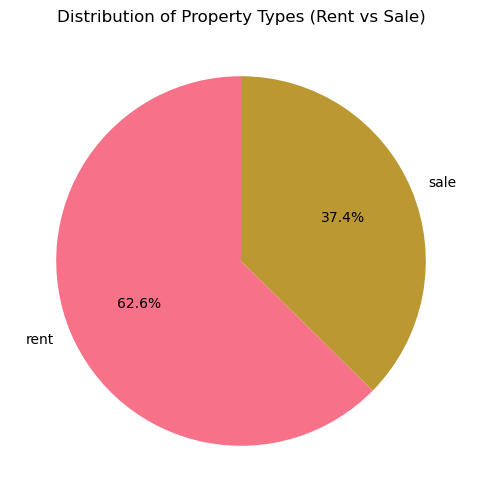

Rental Listings: 476
Sale Listings: 284


In [25]:
# Visualization 1: Transaction Type Distribution
plt.figure(figsize=(10, 6))
transaction_counts = enhanced_df['transaction_type'].value_counts()
plt.pie(transaction_counts.values, labels=transaction_counts.index, autopct='%1.1f%%', startangle=90)
plt.title('Distribution of Property Types (Rent vs Sale)')
plt.show()

print(f"Rental Listings: {len(enhanced_df[enhanced_df['transaction_type'] == 'rent'])}")
print(f"Sale Listings: {len(enhanced_df[enhanced_df['transaction_type'] == 'sale'])}")

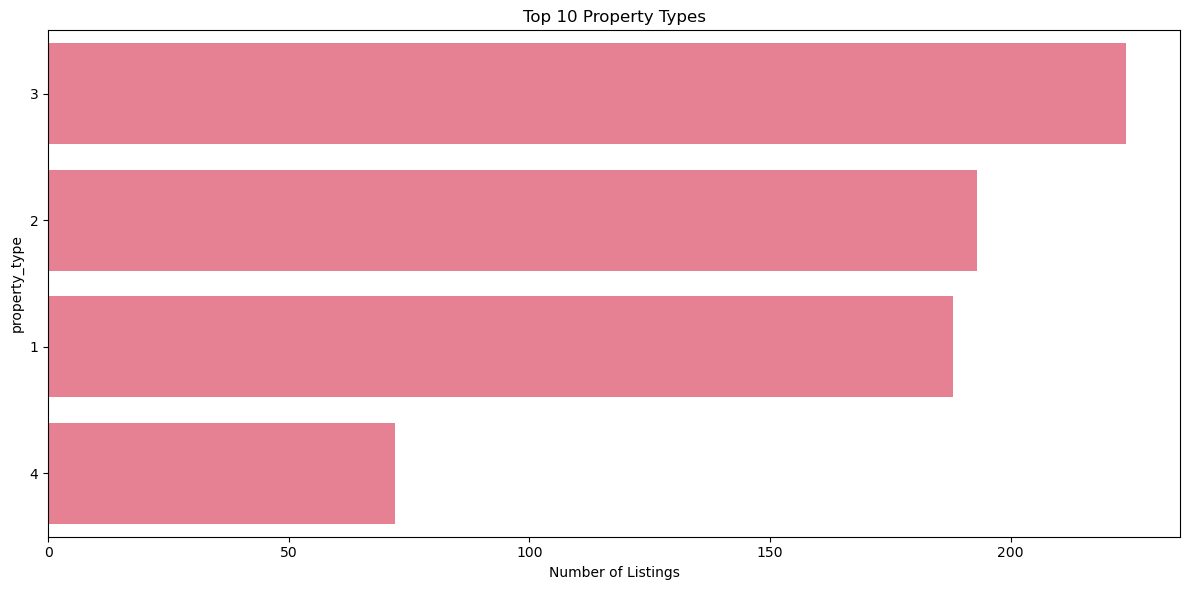

In [27]:
# Visualization 2: Property Type Distribution
plt.figure(figsize=(12, 6))
property_counts = enhanced_df['property_type'].value_counts().head(10)
sns.barplot(x=property_counts.values, y=property_counts.index)
plt.title('Top 10 Property Types')
plt.xlabel('Number of Listings')
plt.tight_layout()
plt.show()

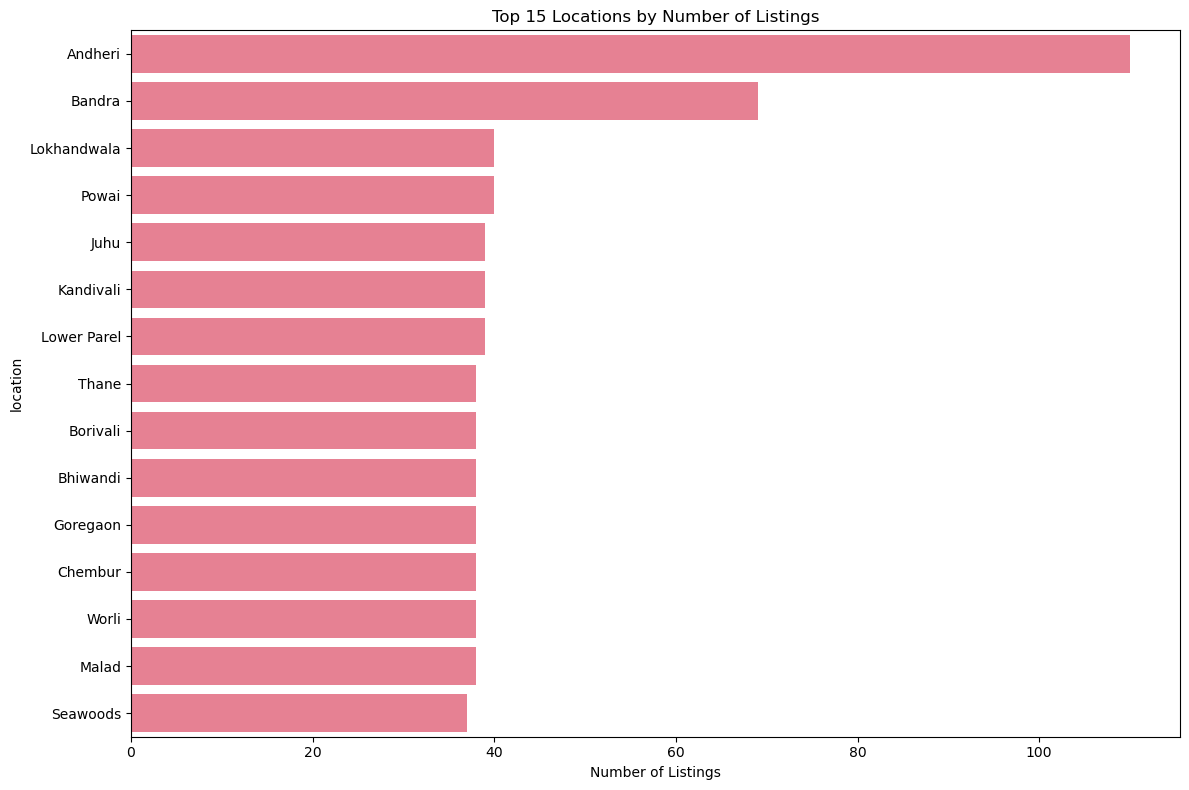

In [29]:
# Visualization 3: Location-wise Listings
plt.figure(figsize=(12, 8))
location_counts = enhanced_df['location'].value_counts().head(15)
sns.barplot(x=location_counts.values, y=location_counts.index)
plt.title('Top 15 Locations by Number of Listings')
plt.xlabel('Number of Listings')
plt.tight_layout()
plt.show()

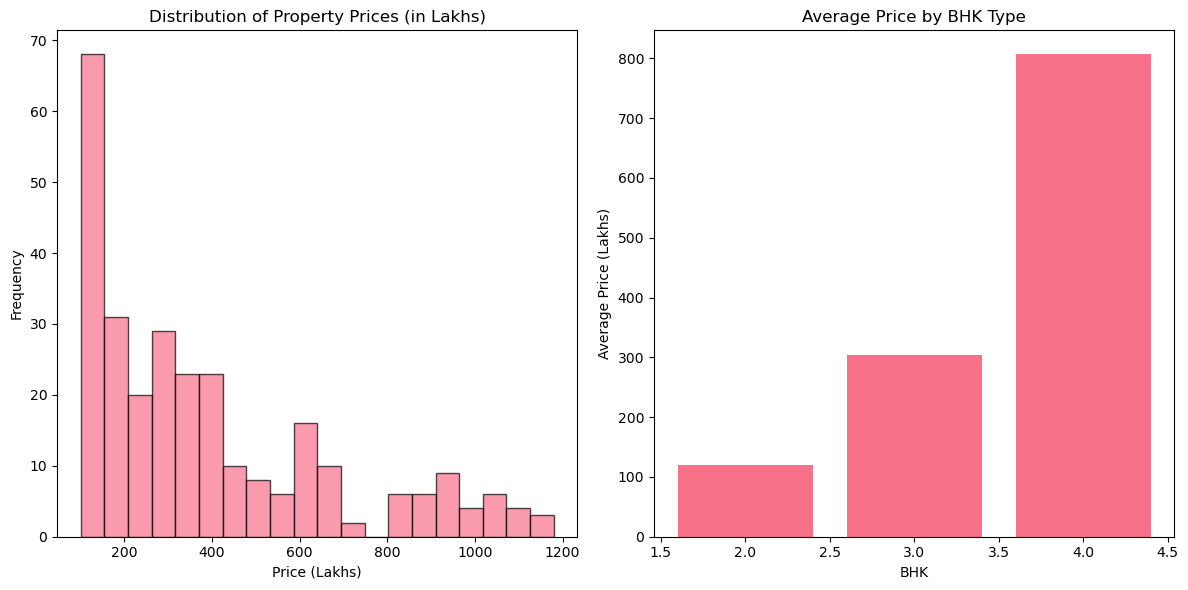

Average Sale Price: 388.02 Lakhs
Most Expensive: 1180.00 Lakhs
Most Affordable: 100.00 Lakhs


In [31]:
# Visualization 4: Price Distribution for Sale Properties
sale_properties = enhanced_df[enhanced_df['transaction_type'] == 'sale'].dropna(subset=['price_lakhs'])

if len(sale_properties) > 0:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(sale_properties['price_lakhs'], bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Property Prices (in Lakhs)')
    plt.xlabel('Price (Lakhs)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    price_by_bhk = sale_properties.groupby('bhk_number')['price_lakhs'].mean().dropna()
    plt.bar(price_by_bhk.index, price_by_bhk.values)
    plt.title('Average Price by BHK Type')
    plt.xlabel('BHK')
    plt.ylabel('Average Price (Lakhs)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average Sale Price: {sale_properties['price_lakhs'].mean():.2f} Lakhs")
    print(f"Most Expensive: {sale_properties['price_lakhs'].max():.2f} Lakhs")
    print(f"Most Affordable: {sale_properties['price_lakhs'].min():.2f} Lakhs")
else:
    print("No sale properties found for price analysis")

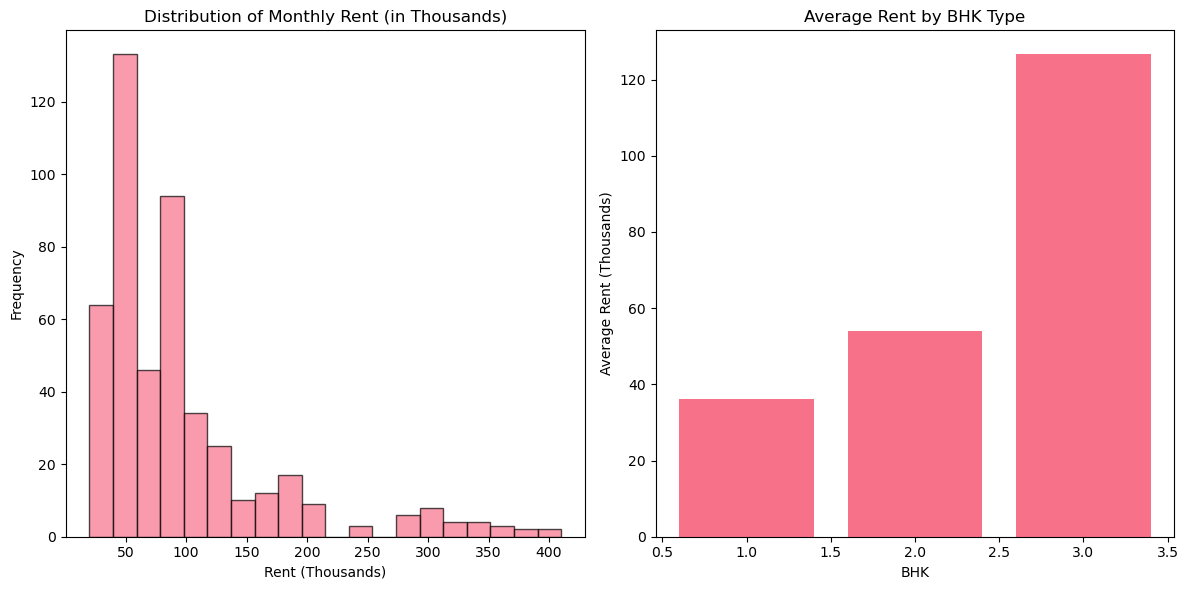

Average Monthly Rent: 94.99 Thousands
Highest Rent: 410.00 Thousands
Lowest Rent: 20.00 Thousands


In [33]:
# Visualization 5: Rent Distribution for Rental Properties
rental_properties = enhanced_df[enhanced_df['transaction_type'] == 'rent'].dropna(subset=['rent_thousands'])

if len(rental_properties) > 0:
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.hist(rental_properties['rent_thousands'], bins=20, edgecolor='black', alpha=0.7)
    plt.title('Distribution of Monthly Rent (in Thousands)')
    plt.xlabel('Rent (Thousands)')
    plt.ylabel('Frequency')
    
    plt.subplot(1, 2, 2)
    rent_by_bhk = rental_properties.groupby('bhk_number')['rent_thousands'].mean().dropna()
    plt.bar(rent_by_bhk.index, rent_by_bhk.values)
    plt.title('Average Rent by BHK Type')
    plt.xlabel('BHK')
    plt.ylabel('Average Rent (Thousands)')
    
    plt.tight_layout()
    plt.show()
    
    print(f"Average Monthly Rent: {rental_properties['rent_thousands'].mean():.2f} Thousands")
    print(f"Highest Rent: {rental_properties['rent_thousands'].max():.2f} Thousands")
    print(f"Lowest Rent: {rental_properties['rent_thousands'].min():.2f} Thousands")
else:
    print("No rental properties found for rent analysis")

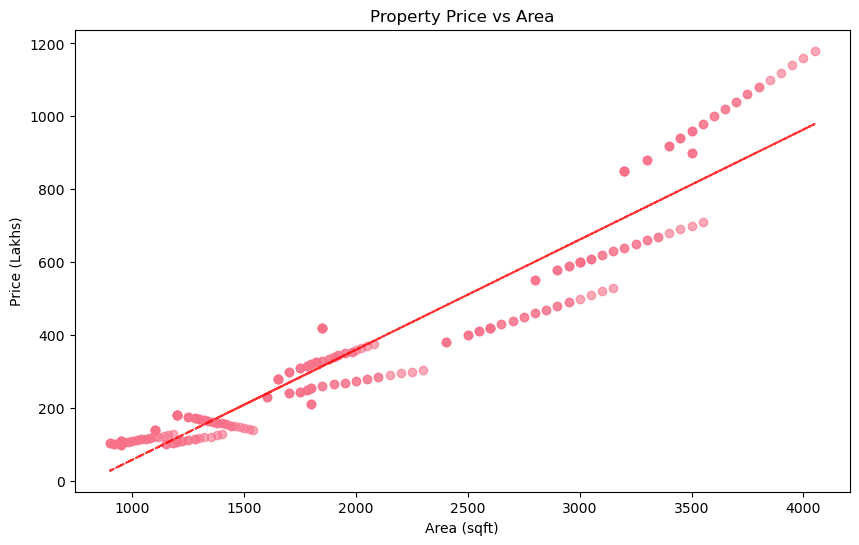

Correlation between Area and Price: 0.95


In [35]:
# Visualization 9: Price vs Area Scatter Plot (Sale Properties)
if len(sale_properties) > 0:
    plt.figure(figsize=(10, 6))
    valid_sale_data = sale_properties.dropna(subset=['price_lakhs', 'area_sqft'])
    
    if len(valid_sale_data) > 0:
        plt.scatter(valid_sale_data['area_sqft'], valid_sale_data['price_lakhs'], alpha=0.6)
        plt.title('Property Price vs Area')
        plt.xlabel('Area (sqft)')
        plt.ylabel('Price (Lakhs)')
        
        # Add trend line
        z = np.polyfit(valid_sale_data['area_sqft'], valid_sale_data['price_lakhs'], 1)
        p = np.poly1d(z)
        plt.plot(valid_sale_data['area_sqft'], p(valid_sale_data['area_sqft']), "r--", alpha=0.8)
        
        plt.show()
        
        # Calculate correlation
        correlation = valid_sale_data['area_sqft'].corr(valid_sale_data['price_lakhs'])
        print(f"Correlation between Area and Price: {correlation:.2f}")